<a href="https://colab.research.google.com/github/Sougotadayglo/Self-supervised_Topic_classification/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling**
Topic modeling is a method for unsupervised classification of documents, similar to clustering, which finds natural groups of items and put them in clusters even when we’re not sure what we’re looking for. In this program we will be extracting clusters of words (sorted according to their weights in) from all the documents, each representing a topic that we will use for Topic classification.

In [ ]:
# mount the google drive where we will store all our
# datasets, models, and intermediate files.

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


install pyLDAvis for visualizing the cluster of words in a 2-Dimensional space.

In [ ]:
pip install pyLDAvis==3.2.2

     |████████████████████████████████| 1.7 MB 9.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135618 sha256=7a69aabb2b52a523b212a82ce991d4dfa7b73f86f842b0fd835b45ba863db018
  Stored in directory: /root/.cache/pip/wheels/f8/b1/9b/560ac1931796b7303f7b517b949d2d31a4fbc512aad3b9f284
Successfully built pyLDAvis


In [ ]:
# import all the modules that we will need throughout the program

import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')

import spacy

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# importing nltk stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Import the Dataset that contains the documents and save it in a dataframe
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/garage-review-dataset.csv',header=None)
df.head()

,0,1
0,Tires where delivered to the garage of my choi...,NaN
1,"Easy Tyre Selection Process, Competitive Prici...",NaN
2,Very easy to use and good value for money.,NaN
3,Really easy and convenient to arrange,NaN
4,It was so easy to select tyre sizes and arrang...,NaN


In [ ]:
# Convert the dataframe field containing the documents into list of documents
data = df[0].values.tolist()
print(df.shape)

(10132, 2)


## Data Pre-processing
The data has to be cleaned before we train our model. This includes removing punctuations, stopwords, symbols, new_line characters, numeric characters etc.

In [ ]:
# pre-process the data
def replace_contractions(text):
    Apos_dict={"'s":" is","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}
  
    #replace the contractions
    for key,value in Apos_dict.items():
        if key in text:
            text=text.replace(key,value)
    return text

# Remove all emails as they are not re
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove URLs
data = [re.sub(r'^https?:\/\/.*[\r\n]*', '', sent) for sent in data]

# Remove symbols
data = [re.sub(r'''["#$%()*+/:;<=>@[\]^_`{|}~]''','', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

#Remove numerals
data = [re.sub(r'[0-9]', '', sent) for sent in data]

data = [replace_contractions(sent) for sent in data]

print(data[:1])

['Tires where delivered to the garage of my choice,the garage notified me when they had been delivered. A day and time was arranged with the garage and I went and had them fitted,a Hassel free experience.']


In [ ]:
#convert the documents into list of words removing extremely small and large words and punctuations

def convert_sentenceToWordsList(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(convert_sentenceToWordsList(data))
print(data_words[:1])

[['tires', 'where', 'delivered', 'to', 'the', 'garage', 'of', 'my', 'choice', 'the', 'garage', 'notified', 'me', 'when', 'they', 'had', 'been', 'delivered', 'day', 'and', 'time', 'was', 'arranged', 'with', 'the', 'garage', 'and', 'went', 'and', 'had', 'them', 'fitted', 'hassel', 'free', 'experience']]


In [ ]:
# Build the bigram and trigram models from the data

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['tires', 'where', 'delivered', 'to', 'the', 'garage', 'of', 'my', 'choice', 'the', 'garage', 'notified', 'me', 'when', 'they', 'had', 'been', 'delivered', 'day', 'and', 'time', 'was', 'arranged', 'with', 'the', 'garage', 'and', 'went', 'and', 'had', 'them', 'fitted', 'hassel', 'free', 'experience']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatize(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

print(data_lemmatized[:2])


[['tire', 'deliver', 'garage', 'choice', 'garage', 'notify', 'deliver', 'day', 'time', 'arrange', 'garage', 'go', 'fit', 'free', 'experience'], ['selection', 'process', 'competitive', 'pricing', 'excellent', 'fitting', 'service']]


In [ ]:
# form bi-gram/tri-grams to capture the context of each word in the documents
# and use them as tokens

data_ready = []

for row in data_lemmatized:
    doc_i = []
    for i in range(len(row)-2):

        # bi-gram of two consecutive words in the diocume4nt
        word = row[i]+'_'+row[i+1]+'_'+row[i+2]
        doc_i.append(word)

    data_ready.append(doc_i)

print(data_ready[:2])

[['tire_deliver_garage', 'deliver_garage_choice', 'garage_choice_garage', 'choice_garage_notify', 'garage_notify_deliver', 'notify_deliver_day', 'deliver_day_time', 'day_time_arrange', 'time_arrange_garage', 'arrange_garage_go', 'garage_go_fit', 'go_fit_free', 'fit_free_experience'], ['selection_process_competitive', 'process_competitive_pricing', 'competitive_pricing_excellent', 'pricing_excellent_fitting', 'excellent_fitting_service']]


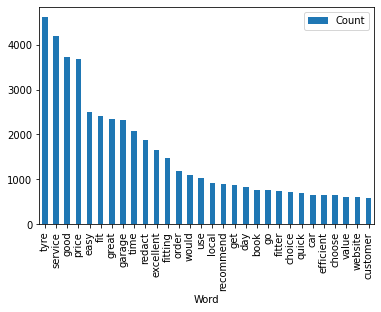

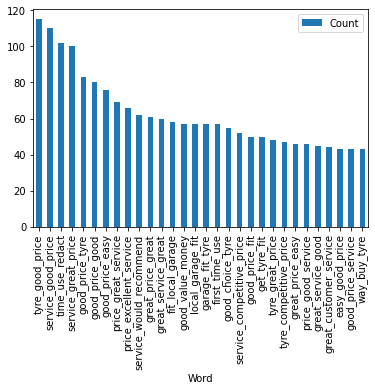

In [ ]:
# plot the graphs of the occurance of most frequent tokens in the document

import collections

word_dict = {}

for row in data_lemmatized:
    for word in row:

        if word not in word_dict:
            word_dict[word] = 1
        else :
            word_dict[word]+=1

word_counter = collections.Counter(word_dict)
lst = word_counter.most_common(30)

df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

# This is for the bi-gram model.

word_dict = {}

for row in data_ready:
    for word in row:

        if word not in word_dict:
            word_dict[word] = 1
        else :
            word_dict[word]+=1

word_counter = collections.Counter(word_dict)
lst = word_counter.most_common(30)

df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=100,no_above=0.5)
id2word.compactify()

id2word_ngram = corpora.Dictionary(data_ready)
id2word_ngram.compactify()

# Create Corpus
texts = data_lemmatized
texts_ngram = data_ready

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
corpus_ngram = [id2word_ngram.doc2bow(text) for text in texts_ngram]

# View
print(corpus[:2])
print(corpus_ngram[:2])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1)], [(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [ ]:
id2word[0] + ' / '+ id2word_ngram[0]

'arrange / arrange_garage_go'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('arrange', 1),
  ('choice', 1),
  ('day', 1),
  ('deliver', 2),
  ('experience', 1),
  ('fit', 1),
  ('garage', 3),
  ('go', 1),
  ('time', 1),
  ('tire', 1)]]

In [ ]:
# Human readable format of corpus_ngram (term-frequency)
[[(id2word_ngram[id], freq) for id, freq in cp] for cp in corpus_ngram[:1]]

[[('arrange_garage_go', 1),
  ('choice_garage_notify', 1),
  ('day_time_arrange', 1),
  ('deliver_day_time', 1),
  ('deliver_garage_choice', 1),
  ('fit_free_experience', 1),
  ('garage_choice_garage', 1),
  ('garage_go_fit', 1),
  ('garage_notify_deliver', 1),
  ('go_fit_free', 1),
  ('notify_deliver_day', 1),
  ('time_arrange_garage', 1),
  ('tire_deliver_garage', 1)]]

## **Latent Dirichlet Allocation : Topic Modeling**
LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

In [ ]:
# create the LDA models
''' 
    The models have been tested with number of topics ranging from 10 to 20
    The results obtained later was best coinciding with num_topics=15.
    Similarly the chunksize and iterations were tested with some random values and most
    optimal was chosen. 

    Future scope : the value of iterations, alpha, beta, chunksize can be optimally chosen
    after running a number of iterations and plotting the coherence score.

'''

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           iterations = 200,
                                           per_word_topics=True)

lda_model_ngram = gensim.models.ldamodel.LdaModel(corpus=corpus_ngram,
                                           id2word=id2word_ngram,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           iterations = 200,
                                           per_word_topics=True)

In [ ]:
# print the topic clusters obtained after training the LDA model.

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

pprint(lda_model_ngram.print_topics())
doc_lda_ngram = lda_model_ngram[corpus_ngram]

[(0,
  '0.063*"tyre" + 0.060*"time" + 0.055*"garage" + 0.050*"fit" + 0.047*"wait" + '
  '0.043*"go" + 0.043*"give" + 0.034*"arrive" + 0.032*"turn" + 0.029*"book"'),
 (1,
  '0.293*"time" + 0.136*"use" + 0.110*"redact" + 0.072*"problem" + '
  '0.061*"first" + 0.057*"issue" + 0.050*"deliver" + 0.037*"second" + '
  '0.026*"experience" + 0.025*"keep"'),
 (2,
  '0.263*"use" + 0.190*"redact" + 0.083*"brilliant" + 0.069*"deal" + '
  '0.066*"fantastic" + 0.060*"reasonable" + 0.054*"year" + 0.054*"have" + '
  '0.043*"reliable" + 0.038*"many"'),
 (3,
  '0.194*"garage" + 0.137*"order" + 0.136*"easy" + 0.090*"tyre" + 0.089*"fit" '
  '+ 0.075*"local" + 0.058*"website" + 0.052*"choose" + 0.032*"online" + '
  '0.021*"arrange"'),
 (4,
  '0.122*"day" + 0.121*"could" + 0.088*"say" + 0.070*"appointment" + '
  '0.044*"email" + 0.038*"change" + 0.037*"would" + 0.037*"book" + '
  '0.036*"booking" + 0.032*"next"'),
 (5,
  '0.455*"service" + 0.446*"excellent" + 0.052*"communication" + '
  '0.028*"provide" + 0.

In [ ]:
# Save the lda models so that they can be directly inferred for future task.

lda_model.save('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/lda_model.model')
lda_model_ngram.save('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/lda_model_tri_gram.model')

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
print('\nPerplexity of n-gram model: ', lda_model_ngram.log_perplexity(corpus_ngram))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_ngram = CoherenceModel(model=lda_model_ngram, texts=data_ready, dictionary=id2word_ngram, coherence='c_v')
coherence_lda_ngram = coherence_model_lda_ngram.get_coherence()
print('\nCoherence Score of n-gram model: ', coherence_lda_ngram)


Perplexity:  -4.5556930341568895

Coherence Score:  0.5285022028274501

Perplexity of n-gram model:  -12.399016703672455

Coherence Score of n-gram model:  0.6971549376192748


In [ ]:
# load the LDA model that has been saved earlier in Topic Modeling
lda_model = gensim.models.ldamodel.LdaModel.load('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/lda_model.model')
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5285022028274501


In [ ]:
# Visualize the topics using the pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.244261 -0.141512       1        1  17.537128
3      0.061595 -0.217730       2        1  11.541818
0      0.207612 -0.146883       3        1   9.137480
13     0.182835 -0.106179       4        1   8.016269
7      0.201086 -0.135230       5        1   7.563417
4      0.167483  0.031104       6        1   7.031551
9      0.077705 -0.144138       7        1   6.641741
8     -0.335448 -0.029039       8        1   6.029678
1      0.128275  0.225329       9        1   4.846512
5     -0.303148  0.017250      10        1   4.646268
11    -0.140114  0.053328      11        1   4.272625
10    -0.062030  0.146277      12        1   3.416466
2      0.077971  0.291922      13        1   3.289540
14     0.059906  0.248699      14        1   3.260006
6     -0.079466 -0.093198      15        1   2.769501, topic_info=          Term         Freq        Total Category  logprob  loglift
16     service  4447.000000  4447.000000  Default  30.0000  30.0000
18        good  3798.000000  3798.000000  Default  29.0000  29.0000
31       great  2213.000000  2213.000000  Default  28.0000  28.0000
11   excellent  1579.000000  1579.000000  Default  27.0000  27.0000
23       price  3538.000000  3538.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
83        line     0.074957   162.403495  Topic15 -10.2444  -4.0944
90       happy     0.074957   267.423288  Topic15 -10.2444  -4.5932
61         job     0.074957   350.940621  Topic15 -10.2444  -4.8650
125       able     0.074957   225.336956  Topic15 -10.2444  -4.4219
74      option     0.074957   155.748343  Topic15 -10.2444  -4.0526

[637 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
125       2  0.213014         able
125       3  0.195263         able
125       6  0.173074         able
125       7  0.417153         able
59        3  0.310737  appointment
...     ...       ...          ...
111      14  0.739248        would
133       4  0.959106        wrong
133       6  0.025922        wrong
126       4  0.122057         year
126      13  0.873671         year

[377 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 1, 14, 8, 5, 10, 9, 2, 6, 12, 11, 3, 15, 7])

In [ ]:
# Visualize the topics for bi-gram model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_ngram, corpus_ngram, id2word_ngram)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.029097 -0.234603       1        1  11.901691
7     -0.021030  0.041377       2        1   7.932267
2     -0.019408  0.014714       3        1   7.257579
9     -0.020293  0.019275       4        1   6.564915
8     -0.018865  0.013588       5        1   6.366059
6     -0.021989  0.023696       6        1   6.365652
4      0.285604 -0.007074       7        1   6.148831
11    -0.020785  0.017296       8        1   6.073627
13    -0.018982  0.010175       9        1   6.068679
0     -0.019433  0.016311      10        1   5.950204
14    -0.020096  0.014489      11        1   5.947699
3     -0.021864  0.024550      12        1   5.904909
10    -0.019181  0.009436      13        1   5.860467
12    -0.014493  0.024210      14        1   5.854728
5     -0.020087  0.012561      15        1   5.802692, topic_info=                             Term       Freq  ...  logprob  loglift
1107              time_use_redact  79.000000  ...  30.0000  30.0000
378            service_good_price  61.000000  ...  29.0000  29.0000
3817      service_would_recommend  53.000000  ...  28.0000  28.0000
1102               first_time_use  46.000000  ...  27.0000  27.0000
60                good_price_good  47.000000  ...  26.0000  26.0000
...                           ...        ...  ...      ...      ...
65091     process_delivery_choose   9.210413  ...  -6.2545   2.7924
65092  recommend_ordering_process   9.210413  ...  -6.2545   2.7924
65093     redact_list_outstanding   9.210413  ...  -6.2545   2.7924
65344          quick_service_time   9.210413  ...  -6.2545   2.7924
65345      service_time_recommend   9.210413  ...  -6.2545   2.7924

[571 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
65127     14  0.927358        able_book_precise
65316     12  0.917573   able_choose_convenient
65057      4  0.942638       address_ask_decent
65831      8  0.997544           agree_car_call
65666     10  0.994052         air_pressure_ask
...      ...       ...                      ...
21849     15  0.943489  would_recommend_company
2133       9  0.989745   would_recommend_redact
7154       5  0.903055  would_recommend_service
22071      3  0.982769        would_redact_good
17452      9  0.951428        wrong_tyre_redact

[572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 3, 10, 9, 7, 5, 12, 14, 1, 15, 4, 11, 13, 6])

In [ ]:
for i, row in enumerate(lda_model[corpus]):
    print(i)
    row = row[0] if lda_model.per_word_topics else row
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    pprint(data[i])
    pprint(lda_model.show_topic(row[0][0]))
    pprint(row)
    if i==20:
        break

0
('Tires where delivered to the garage of my choice,the garage notified me when '
 'they had been delivered. A day and time was arranged with the garage and I '
 'went and had them fitted,a Hassel free experience.')
[('garage', 0.19422932),
 ('order', 0.13737556),
 ('easy', 0.13606744),
 ('tyre', 0.09034697),
 ('fit', 0.089280844),
 ('local', 0.07492117),
 ('website', 0.057775754),
 ('choose', 0.05164137),
 ('online', 0.03173607),
 ('arrange', 0.02086424)]
[(3, 0.414533),
 (1, 0.22969262),
 (7, 0.16017222),
 (4, 0.08377884),
 (12, 0.036065485),
 (8, 0.011118108)]
1
'Easy Tyre Selection Process, Competitive Pricing and Excellent Fitting Service'
[('good', 0.28312075),
 ('price', 0.23052943),
 ('service', 0.118772425),
 ('tyre', 0.06999477),
 ('fitting', 0.063733816),
 ('choice', 0.042350315),
 ('competitive', 0.035598543),
 ('easy', 0.026968574),
 ('fast', 0.01903331),
 ('quality', 0.018926708)]
[(12, 0.4118818),
 (5, 0.19685459),
 (11, 0.121317655),
 (14, 0.11848417),
 (3, 0.026596654

In [ ]:
for i, row in enumerate(lda_model_ngram[corpus_ngram]):
    print(i)
    row = row[0] if lda_model_ngram.per_word_topics else row
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    pprint(data[i])
    pprint(lda_model_ngram.show_topic(row[0][0]))
    pprint(row)
    if i==20:
        break

0
('Tires where delivered to the garage of my choice,the garage notified me when '
 'they had been delivered. A day and time was arranged with the garage and I '
 'went and had them fitted,a Hassel free experience.')
[('fit_would_recommend', 0.002547496),
 ('easy_ordering_process', 0.002535892),
 ('great_selection_tyre', 0.002479337),
 ('go_local_garage', 0.0023580058),
 ('price_good_communication', 0.0022716369),
 ('redact_many_year', 0.0022432872),
 ('price_customer_service', 0.002118376),
 ('mobile_fitting_service', 0.0021042104),
 ('time_need_tyre', 0.0021037478),
 ('website_competitive_price', 0.0020917226)]
[(1, 0.9627015)]
1
'Easy Tyre Selection Process, Competitive Pricing and Excellent Fitting Service'
[('service_good_price', 0.0127019575),
 ('good_price_tyre', 0.007872222),
 ('use_redact_time', 0.005819583),
 ('good_service_good', 0.0043561137),
 ('fit_local_garage', 0.0038846908),
 ('good_price_quick', 0.0038408453),
 ('great_service_good', 0.0034108327),
 ('book_time_slot',

This part is optional.
If we want to select the optimal value of num_topics, alpha, beta, and other hyper parameters, we use a number of permutations of all the hyper-parameters and select the one that gives the largest coherence score.
#===================================================================#

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           iterations = 200,
                                           alpha='auto',
                                           per_word_topics=True)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        model_list.append(lda_model)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=20, step=100)

In [ ]:
# Show graph
limit=25; start=12; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[20]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

#===================================================================#

Create a dataframe with the most dominant topic for each document.

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4144,"garage, order, easy, tyre, fit, local, website...",Tires where delivered to the garage of my choi...
1,1,12.0,0.4120,"good, price, service, tyre, fitting, choice, c...","Easy Tyre Selection Process, Competitive Prici..."
2,2,6.0,0.4792,"value, cheap, money, easy, brand, lot, redacte...",Very easy to use and good value for money.
3,3,9.0,0.3527,"time, fitting, work, book, job, do, convenient...",Really easy and convenient to arrange
4,4,3.0,0.4319,"garage, order, easy, tyre, fit, local, website...",It was so easy to select tyre sizes and arrang...
5,5,3.0,0.2722,"garage, order, easy, tyre, fit, local, website...",service was excellent. Only slight downside wa...
6,6,12.0,0.4098,"good, price, service, tyre, fitting, choice, c...",User friendly Website. Competitive Prices. Goo...
7,7,5.0,0.3799,"service, excellent, communication, provide, fi...",Excellent prices and service
8,8,7.0,0.3566,"tyre, fit, buy, redact, get, want, find, need,...",It was very straightforward and the garage was...
9,9,3.0,0.5271,"garage, order, easy, tyre, fit, local, website...",Use of local garage.


# **Creating the dataset for Supervised classification : MULTI LABEL CLASSIFICATION**

Create a dataframe and store it in a .csv file. There are 15 labels each representingt topic cluster obtained from the lda model. For each document if a particular topic cluster has a weight value of more than 20% then that topic label is marked as 1 or else 0. This dataframe is compatible for training the ML models like Logistic regression, SVM etc and DL models using keras. that is used for classification of the documents.

In [ ]:
def create_labels(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame(columns = ['Label1','Label2','Label3','Label4','Label5','Label6',
                              'Label7','Label8','Label9','Label10','Label11','Label12',
                              'Label13','Label14','Label15'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        label = [0] * 15
        for j, (topic_num, prop_topic) in enumerate(row):
            if prop_topic > 0.20:  
                label[topic_num] = 1
            else:
                label[topic_num] = 0
        
        sent_topics_df.loc[i] = label

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df['Text'] = contents
    return(sent_topics_df)


df_topic_sents_keywords = create_labels(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_annotated = df_topic_sents_keywords.reset_index()
df_annotated.columns = ['Document_No','Label1','Label2','Label3','Label4','Label5','Label6',
                        'Label7','Label8','Label9','Label10','Label11','Label12',
                        'Label13','Label14','Label15','Text']
df_annotated.head(5)

,Document_No,Label1,Label2,Label3,Label4,Label5,Label6,Label7,Label8,Label9,Label10,Label11,Label12,Label13,Label14,Label15,Text
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,Tires where delivered to the garage of my choi...
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"Easy Tyre Selection Process, Competitive Prici..."
2,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,Very easy to use and good value for money.
3,3,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Really easy and convenient to arrange
4,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,It was so easy to select tyre sizes and arrang...


In [ ]:
#saving the dataset
# Remove rows containing empty/NaN values
nan_value = float("NaN")
df_annotated.replace('',nan_value,inplace=True)
df_annotated.dropna(inplace=True)
print(df_annotated.shape)

df_annotated.to_csv('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/annotated_dataset_multi_label.csv', index = False)

(10130, 17)


# **Creating the dataset for Supervised classification : MULTI-CLASS CLASSIFICATION**

In [ ]:
def create_labels(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame(columns = ['Label1','Label2','Label3','Label4','Label5','Label6',
                              'Label7','Label8','Label9','Label10','Label11','Label12',
                              'Label13','Label14','Label15'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        label = [0] * 15
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                label[topic_num] = 1
            else:
                label[topic_num] = 0
        
        sent_topics_df.loc[i] = label

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df['Text'] = contents
    return(sent_topics_df)


df_topic_sents_keywords = create_labels(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_annotated = df_topic_sents_keywords.reset_index()
df_annotated.columns = ['Document_No','Label1','Label2','Label3','Label4','Label5','Label6',
                        'Label7','Label8','Label9','Label10','Label11','Label12',
                        'Label13','Label14','Label15','Text']
df_annotated.head(5)

,Document_No,Label1,Label2,Label3,Label4,Label5,Label6,Label7,Label8,Label9,Label10,Label11,Label12,Label13,Label14,Label15,Text
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Tires where delivered to the garage of my choi...
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,"Easy Tyre Selection Process, Competitive Prici..."
2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,Very easy to use and good value for money.
3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Really easy and convenient to arrange
4,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,It was so easy to select tyre sizes and arrang...


In [ ]:
# Remove rows containing empty/NaN values
nan_value = float("NaN")
df_annotated.replace('',nan_value,inplace=True)
df_annotated.dropna(inplace=True)
print(df_annotated.shape)

df_annotated.to_csv('/content/gdrive/MyDrive/Colab Notebooks/TopicModelingAndClassification/annotated_dataset_multi_class.csv', index = False)

(10130, 17)
